# An interactive notebook to learn the thermodynamics of ideal solutions 

*Authors: Enze Chen (University of California, Berkeley)*

This is an interactive notebook for playing around with the temperature and observing the effect on the resulting free energy curves of a binary ideal solution. Following that, there is a small section for readers to complete their own code to generate the phase diagram for the ideal solution. There are [similar demos](http://www.learncheme.com/simulations/thermodynamics/thermo-2/effect-of-temperature-on-partial-miscibility) available online, but I couldn't find one that was interactive in this way and written in Python. Thermodynamics is fairly math-heavy and a tough subject to master, but I believe having quality visualizations can have a large, positive impact on your learning. I hope you will find this notebook functional, readable, and educational.

## Usage

### Part 1
In the first half of this notebook, everything is completed for you and you just have to run it. To execute each cell of the notebook and automatically advance to the next cell, press `Shift+Enter`. Or you can click `Run All` in the menu at the top. When done successfully, you'll see a widget slider pop up that you can adjust and observe the changes.

### Part 2
In the second half, there are places for you to complete the code in order to construct the resulting phase diagram. These are delineated with the dashed lines as follows, and you should **only change what's inside**. You don't have to edit the text or code anywhere else.
```python
# ---------------------- #
# YOUR CODE HERE

# ---------------------- #
```
If you edit the code in a cell, just press `Shift+Enter` to run it again. You have to execute **all** the code cells in this notebook from top to bottom (so don't skip around). A number `[#]` will appear to the left of the code cell once it's done executing. When done successfully, you'll be able to generate a lens-shaped phase diagram at the very end.

## Acknowledgements
I thank [Prof. Gerbrand Ceder](https://mse.berkeley.edu/people_new/ceder/) for teaching MATSCI 201A: Thermodynamics and Phase Transformations in Solids and my advisor [Prof. Mark Asta](https://mse.berkeley.edu/people_new/asta/) for conceiving this idea, providing preliminary scripts and data, and encouraging me in my education-related pursuits. Interactivity is enabled with the [`ipywidgets`](https://ipywidgets.readthedocs.io/en/stable/) library. An interactive version of this notebook can be found online at [Google Colaboratory](https://colab.research.google.com/github/enze-chen/enze-chen.github.io/blob/master/files/Ideal_solution_plots.ipynb).

## Important equations

We know from thermodynamics that in general,

$$ \Delta G = \Delta H - T \Delta S$$

where $\Delta H$ is the enthalpy, $T$ is the temperature, and $\Delta S$ is the entropy. Hopefully this is ingrained in your head by now.

Since we are working with ideal solutions, $\Delta H_{\text{mix}} = 0$ and the entropy of mixing is given by

$$ \Delta S_{\text{mix}} = -R (x \ln x + (1-x) \ln(1-x)) $$

Furthermore, we'll assume for this demo that the ethalpies of the pure solid phases are $0$ (reference) and that the molar free energy differences between the liquid and solid phases at these pure endpoints can be approximated by

$$ \Delta G_m^{0}(T) = \Delta G^{s \rightarrow l}(T) = \Delta S_m^0 [T_m - T] $$


## Assumptions
* I assumed ideal solution behavior for the solid and liquid solutions.
* I assumed that the two curves would be convex for my optimization routine.

## Python library imports

These are all the required Python libraries.

In [1]:
# General libraries
import warnings
warnings.filterwarnings('ignore')  # please do as I say, not as I do

# Scientific computing libraries
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
%matplotlib inline

# Interactivity libraries
from ipywidgets import interact, interact_manual, fixed, \
                       IntSlider, FloatSlider, FloatLogSlider, RadioButtons, \
                       Button, Layout

## Analytical functions

Here are the theoretical curves for the Gibbs free energy ($\Delta G$) of the solid and liquid phases, with data taken from forserite ($\text{Mg}_2\text{SiO}_4$) and fayalite ($\text{Fe}_2\text{SiO}_4$). We define $x$ to be the atomic fraction of $\text{Fe}$, which substitutes on the $\text{Mg}$ sites.

In [2]:
def curve_s(x, T, R=8.314):
    """This function plots the Gibbs free energy curve for the solid solution.
    
    Args:
        x (numpy.darray): An array of atomic fractions of Fe.
        T (float): The temperature in Kelvin
        R (float): The ideal gas constant in J/(mol*K)
        
    Returns:
        G_s (numpy.darray): An array of Gibbs free energy values in kilojoules.    
    """
    S_Fo, S_Fa = (52.7, 59.9)
    S_mix = -R * (np.multiply(x, np.log(x)) + np.multiply(1 - x, np.log(1 - x)))
    G_s = -T * S_mix
    return G_s / 1000

def curve_l(x, T, R=8.314):
    """This function plots the Gibbs free energy curve for the liquid solution.
    
    Args:
        x (numpy.darray): An array of atomic fractions of Fe.
        T (float): The temperature in Kelvin
        R (float): The ideal gas constant in J/(mol*K)
        
    Returns:
        G_l (numpy.darray): An array of Gibbs free energy values in kilojoules.    
    """
    S_Fo, S_Fa = (52.7, 59.9)
    T_Fo, T_Fa = (1890 + 273, 1205 + 273)
    G_Fo = S_Fo * (T_Fo - T)
    G_Fa = S_Fa * (T_Fa - T)
    S_mix = -R * (np.multiply(x, np.log(x)) + np.multiply(1 - x, np.log(1 - x)))
    G_l = x * G_Fa + (1 - x) * G_Fo - T * S_mix
    return G_l / 1000

## Constructing the common tangent

There are many ways one could go about doing this. I've seen people in the past do a brute force enumeration (\*shudder\*). John Dagdelen suggests a Legendre transform (nifty!). I got really excited about trying gradient descent optimization (yeet). Eventually, after much Googling and consideration, I went with something simple and relatively fast, inspired from [this StackOverflow answer](https://stackoverflow.com/a/10271179). The procedure is as follows:

1. Using `scipy`, compute a derivative of curve 1, $\Delta G^s$, and store this for later use.
1. Pick the minimum of curve 1 as an initial guess as the common tangent will be close to there.
1. Using the derivative and coordinates, construct the tangent line at the minimum.
1. Extend the tangent line and see if it intersects curve 2, $\Delta G^l$.
    1. **If so**, shift the tangent point *left* on curve 1 and continue building tangent lines of decreasing slope.
        1. Repeat step 4.
        1. As soon as an extended tangent line *misses* curve 2, **stop**.
    1. **If not**, shift the tangent point right on curve 1 and continue building tangent lines of increasing slope.
        1. Repeat step 4.
        1. As soon as an extended tangent line *intersects* curve 2, **stop**.
1. Identify where the common tangent intersects the two curves so we only plot that portion.

In [3]:
def common_tangent(x, y1, y2, T):
    """This function calculates the common tangent of two convex curves.
    
    Args:
        x (numpy.darray): An array of atomic fractions of Fe.
        y1 (numpy.darray): y values for curve 1.
        y2 (numpy.darray): y values for curve 2.
        T (float): The temperature in Kelvin
        
    Returns:
        line (numpy.darray): y values for the common tangent.
        idmin (int): Index of the x-coordinate of the first tangent point.
        idmax (int): Index of the x-coordinate of the second tangent point.
    """
    # Compute a derivative
    dx = 1e-3
    dy1 = derivative(func=curve_s, x0=x, dx=dx, args=(T,))

    # Make an initial guess at the minimum of curve 1
    idmin, idmax = (0, len(x))
    idx = np.argmin(y1)
    yp = y1[idx]
    xp = x[idx]
    dyp = dy1[idx]

    # Construct the tangent line and count intersections with curve 2
    line = dyp * x + yp - dyp * xp
    diff = np.diff(np.sign(y2 - line))
    nnz = np.count_nonzero(diff)

    # If the tangent line misses curve 2, shift tangent point to the right
    if nnz < 1:
        while nnz < 1:
            idx += 1
            # try-except to avoid an out-of-bounds error 
            try:
                yp = y1[idx]
                xp = x[idx]
                dyp = dy1[idx]
                line = dyp * x + yp - dyp * xp
                diff = np.diff(np.sign(y2 - line))
                nnz = np.count_nonzero(diff)
            except:
                break
        # Assign left and right indices of the tangent points
        idmin = idx
        idmax = np.nonzero(diff)[0][0]
    # If the tangent line intersects curve 2, shift tangent point to the left
    elif nnz >= 1:
        while nnz >= 1:
            idx -= 1
            # try-except to avoid an out-of-bounds error 
            try:
                yp = y1[idx]
                xp = x[idx]
                dyp = dy1[idx]
                line = dyp * x + yp - dyp * xp
                diff = np.diff(np.sign(y2 - line))
                nnz = np.count_nonzero(diff)
            except:
                break
            if diff.any():
                # Assign left and right indices of the tangent points
                # Here we do it each time because once we miss, we can't go back
                idmax = np.nonzero(diff)[0][0]
        idmin = idx
    return (line, idmin, idmax)

## Widget function

Our widget will call `plot_Gx()` each time we interact with it. This function calls `curve_s()` and `curve_l()` to get the solid and liquid free energy curves, respectively. It then calls the `optimize()` function above to calculate the common tangent to the two curves. The rest of the function handles the plotting, where I specifically chose to lock the $y$-axis to emphasize how much $\Delta G^l$ changes as a function of temperature compared to $\Delta G^s$.

In [4]:
def plot_Gx(T=1800):
    """This function is called by the widget to perform the plotting based on inputs.
    
    Args:
        T (float): The temperature in Kelvin
        
    Returns:
        None, but a pyplot is displayed.
    """
    # For the given temperature, calculate the curves and common tangent
    n = int(1e4)
    xmin, xmax = (0.001, 0.999)
    x = np.linspace(xmin, xmax, n)
    y_s = curve_s(x, T)
    y_l = curve_l(x, T)
    line, idmin, idmax = common_tangent(x, y_s, y_l, T)

    # Mostly plot settings for visual appeal
    plt.rcParams.update({'figure.figsize':(8,6), 'font.size':20, 'font.family':'Arial', \
                         'lines.linewidth':4, 'axes.linewidth':2})
    fig, ax = plt.subplots()
    ax.plot(x, y_s, c='C0', label='solid')
    ax.plot(x, y_l, c='C1', label='liquid')
    ax.plot(x[idmin:idmax], line[idmin:idmax], c='k', lw=6, ls='-.')
    for side in ['bottom']:
        ax.spines[side].set_visible(False)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, \
                   direction='in', length=10, width=2)
    ax.set_xlim(0, 1)
    ax.set_ylim(-40, 40)
    ax.set_xlabel(r'$x_{Fe}$')
    ax.xaxis.set_label_coords(0.9, 1.12)
    ax.set_ylabel(r'$\Delta G$ (kJ/mol)')
    ax.set_title('Gibbs free energy at T = {} K'.format(T), fontsize=18)
    plt.legend()
    plt.show()

We create each slider individually for readability and customization.

In [5]:
T_widget = IntSlider(value=1800, min=1400, max=2200, step=50, \
                     description='Temperature (K)', readout_format='d', \
                     style={'description_width':'100px'}, \
                     layout=Layout(width='400px', height='30px'), \
                     continuous_update=False)

Each time you release your mouse, the plot will automatically update! This is because we specified `continuous_update=False` in the constructor.

In [6]:
interact(plot_Gx, T=T_widget);

interactive(children=(IntSlider(value=1800, continuous_update=False, description='Temperature (K)', layout=Lay…

--------------------------------------------
--------------------------------------------

## Creating the phase diagram

Now that we have everything set up, it's your job to finish off the notebook. Before taking 201A, it did not occur to me that the data above actually correspond to a phase diagram. I guess that just wasn't emphasized in my undergraduate studies or I simply dozed off. **/shrug**

But they do! Specifically, the common tangent indicates, for a specific $T$, the region of solid-liquid coexistence. The two tangent points on the solid and liquid curves lie on the solidus and liquidus curves, respectively. Knowing this, we'll now loop through a few values of $T$ (`Ts`) to obtain a set of x-coordinates and then construct the phase diagram from them.

In [7]:
# Enumerate the temperatures we want to calculate phase boundaries at. 
# 9 points give enough detail without being too computationally expensive.
Ts = np.linspace(1480, 2160, 9)

# Create empty arrays to track the x-coordinates of the boundaries
liquidus = []
solidus = []

# Same x-axis as before
n = int(1e4)
xmin, xmax = (0.001, 0.999)
x = np.linspace(xmin, xmax, n)

**TODO**: Your job is to figure out where the common tangent points are for each value of $T$. If you didn't change any of the above data or code, you may assume that each value of $T$ in `Ts` has two tangent points. Once you figure out the x-coordinates of these points, store them into the correct array, either `liquidus` or `solidus`.

Hints:
* You should shoot for around 6-8 lines of code. Any more than 10 and you might be on the wrong track.
* Look at `plot_Gx()` for some inspiration of how to obtain the x-coordinates of the common tangent.
* Since the code in `plot_Gx()` work for a single `T`, you'll want to nest what you write below inside a [for loop](https://www.w3schools.com/python/python_for_loops.asp) for the `Ts` array.
* Given an index `i`, the value of array `x` at index `i` is given by `x[i]`.
* To add an element to the end of a Python array such as `liquidus`, type `liquidus.append(your_value)`.

In [8]:
# ---------------------- #
# YOUR CODE HERE

# ---------------------- #

If you've filled up your `liquidus` and `solidus` arrays correctly, the following code should plot the phase diagram. You'll see the solidus curve in blue and liquidus curve in orange. Dots mark the specific points you calculated.

ValueError: x and y must have same first dimension, but have shapes (0,) and (9,)

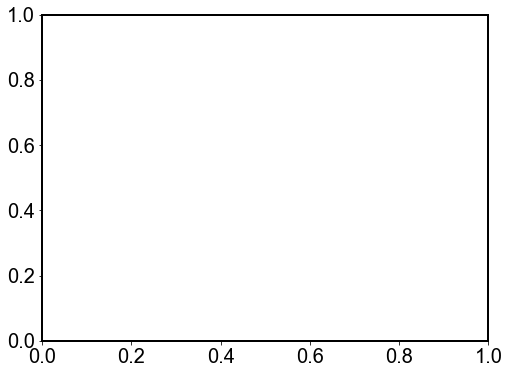

In [9]:
plt.rcParams.update({'figure.figsize':(8,6), 'font.size':20, 'font.family':'Arial', \
                     'lines.linewidth':4, 'lines.markersize':15, 'axes.linewidth':2})
fig, ax = plt.subplots()
ax.plot(liquidus, Ts, '-o', c='C1', label='liquidus')
ax.plot(solidus, Ts, '-o', c='C0', label='solidus')
ax.annotate(s='solid', xy=(0.45, 1400))
ax.annotate(s='solid+liquid', xy=(0.4, 1750))
ax.annotate(s='liquid', xy=(0.45, 2150))
ax.tick_params(right=True, direction='in', length=10, width=2)
ax.set_xlim(0, 1)
ax.set_ylim(1100, 2500)
ax.set_xlabel(r'$x_{Fe}$')
ax.set_ylabel(r'$T$ (K)')
plt.legend()
plt.show()

## Conclusion
Congratulations on making it to the end! I hope this notebook helped you with visualizing the thermodynamics of ideal solutions and gave you some scientific computing practice. If you have any remaining questions or ideas for this and other modules, please don't hesitate to reach out.